In [16]:
import numpy as np
import cv2
import struct
import math
import time
import os
import math
import time
import sys
import PIL
from models import *
import torchvision.transforms as transforms
from torch.autograd import Variable
#from models import *
import torch.nn as nn
import torch.nn.functional as F
import torch
from ssd import build_ssd
import matplotlib.pyplot as plt

In [60]:
width = 640
height = 480
cuda = True if torch.cuda.is_available() else False
prob_threshold = 0.3
border = 0
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
data_transform = transforms.Compose([transforms.Resize((256, 256), PIL.Image.BICUBIC),
                transforms.ToTensor()])
net = build_ssd('test', 300, 4)    # initialize SSD
net.load_weights('/media/arg_ws3/5E703E3A703E18EB/ssd300_subt_280000.pth')
generator = GeneratorUNet(in_channels=3, out_channels=1)
generator.load_state_dict(torch.load('/media/arg_ws3/5E703E3A703E18EB/research/pix2pix_cropmask/saved_models/rgb/generator_10.pth'))
if cuda:
    net = net.cuda()
    generator = generator.cuda()

Loading weights into state dict...
Finished!


In [61]:
def generate_image(bbx_img):
    bbx_img = cv2.cvtColor(bbx_img, cv2.COLOR_RGB2BGR)
    pil_im = PIL.Image.fromarray(bbx_img)
    pil_im = data_transform(pil_im)
    pil_im = pil_im.unsqueeze(0)
    my_img = Variable(pil_im.type(Tensor))
    my_img_fake = generator(my_img)
    my_img_fake = my_img_fake.squeeze(0).detach().cpu()
    pil_ = my_img_fake.mul(255).clamp(0, 255).byte().permute(1, 2, 0)
    pil_ = np.array(pil_)
    pil_ = pil_[...,::-1]
    #generate_img = cv2.resize(generate_img, (640, 480))
    #mask_dilate()
    #print("Hz: ", 1./(time.time() - prev_time))
    return pil_

In [62]:
def mask_dilate():
    mask = np.zeros(generate_img.shape, np.uint8)
    ret, mask = cv2.threshold(generate_img, 500, 255, cv2.THRESH_BINARY)
    mask = 255 - mask
    kernel = np.ones((10,10),np.uint8)
    mask = cv2.dilate(mask, kernel, iterations = 1)
    mask = 255 - mask
    for j in range(mask.shape[0]):
        for i in range(mask.shape[1]):
            if mask[j][i] == 0:
                generate_img[j][i] = 0

In [63]:
def predict(image):
    h, w = image.shape[:2]
    tmp_img = image.copy()
    generate_img = np.zeros(image.shape, np.uint8)
    # generate_img = image.copy()
    img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    x = cv2.resize(img, (300, 300)).astype(np.float32)
    x -= (104.0, 117.0, 123.0)
    x = x.astype(np.float32)
    x = x[:, :, ::-1].copy()
    x = torch.from_numpy(x).permute(2, 0, 1)

    #SSD Forward Pass
    xx = Variable(x.unsqueeze(0))     # wrap tensor in Variable
    if torch.cuda.is_available():
        xx = xx.cuda()
    y = net(xx)
    # print(1./(t2-t1))
    scale = torch.Tensor(image.shape[1::-1]).repeat(2)
    detections = y.data	# torch.Size([1, 4, 200, 5]) --> [batch?, class, object, coordinates]
    objs = []
    for i in range(detections.size(1)): # detections.size(1) --> class size
        for j in range(5):	# each class choose top 5 predictions
            if detections[0, i, j, 0].numpy() > prob_threshold:
                score = detections[0, i, j, 0]
                pt = (detections[0, i, j,1:]*scale).cpu().numpy()
                objs.append([pt[0], pt[1], pt[2]-pt[0]+1, pt[3]-pt[1]+1, i])
    for obj in objs:
        region = [int(obj[1] - border), int(obj[1] + obj[3] + border),\
                  int(obj[0] - border), int(obj[0] + obj[2] + border)]

        bbx_img = image[region[0] : region[1], region[2]: region[3]]
        if bbx_img.shape[0] == 0 or bbx_img.shape[1]==0:
            continue

        mask = generate_image(bbx_img)
        # lis = []
        # for i in range(mask.shape[0]):
        # 	for j in range(mask.shape[1]):
        # 		if mask[i][j] not in lis:
        # 			lis.append(mask[i][j])
        # print(lis)
        mask = cv2.resize(mask, (region[3]-region[2], region[1]-region[0]))
        ret, mask = cv2.threshold(mask, 100, obj[4]+1, cv2.THRESH_BINARY) # pixel value only belongs to 0 or 255
        if generate_img[region[0] : region[1], region[2]: region[3]].shape[:2] == mask.shape:
            generate_img[region[0] : region[1], region[2]: region[3]] = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
            if obj[4] == 0:
                cv2.rectangle(tmp_img, (int(obj[0]), int(obj[1])),\
                (int(obj[0] + obj[2]), int(obj[1] + obj[3])), (255, 255, 0), 3)
            elif obj[4] == 1:
                cv2.rectangle(tmp_img, (int(obj[0]), int(obj[1])),\
                (int(obj[0] + obj[2]), int(obj[1] + obj[3])), (0, 255, 0), 3)
            elif obj[4] == 2:
                cv2.rectangle(tmp_img, (int(obj[0]), int(obj[1])),\
                (int(obj[0] + obj[2]), int(obj[1] + obj[3])), (255, 255, 0), 3)
            elif obj[4] == 3:
                cv2.rectangle(tmp_img, (int(obj[0]), int(obj[1])),\
                (int(obj[0] + obj[2]), int(obj[1] + obj[3])), (255, 255, 0), 3)
    generate_img_draw = generate_img.copy()
    generate_img_draw[generate_img_draw > 0] = 255

    generate_img = generate_img[:,:,0]
    return generate_img

In [72]:
cv_image = cv2.imread("/media/arg_ws3/5E703E3A703E18EB/data/subt_all/image/drill/scene000003/2.jpg")
generate_img = predict(cv_image)

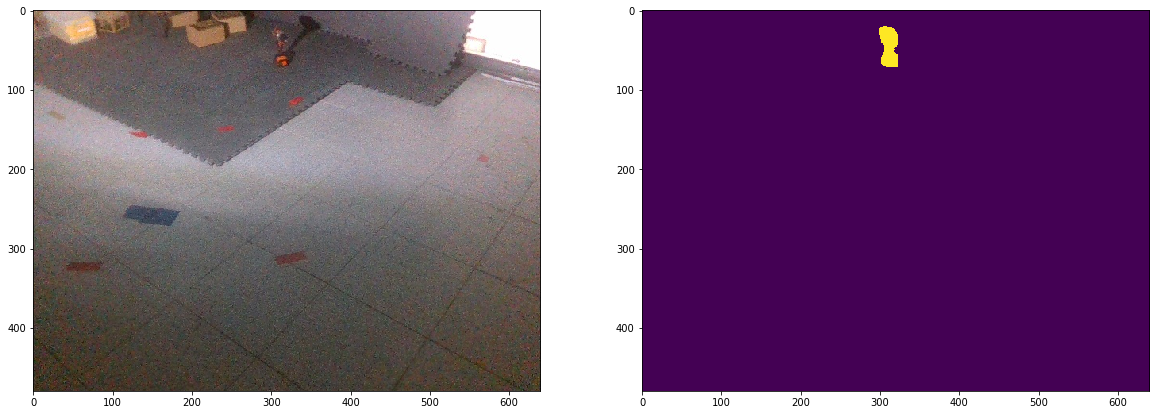

In [73]:
fig=plt.figure(figsize=(20, 20))
fig.add_subplot(1,2,1)
plt.imshow(cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB))
fig.add_subplot(1,2,2)
plt.imshow(generate_img)
plt.show()

In [66]:
cv2.imwrite("ss.png", generate_img)

True